In [17]:
import torch
from PIL import Image
from sklearn.model_selection import train_test_split
from torch import nn, optim
import torch.nn.functional as F
from torchvision.ops import focal_loss
import torchvision.transforms.functional as transF
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import os
from torch.utils.data import random_split
import random
from sklearn import preprocessing
from tqdm import tqdm
import cv2
from sklearn.metrics import confusion_matrix

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [19]:
class CFG:
    '''
    CFG
    Define hyperparameters used for preprocessing data and training model
    ----------
    Attributes
    ----------
        num_epochs: int
            Number of epochs need for training.
        batch_size: int
            Number of samples used for training in 1 iteration.
        num_workers: int
            Number of processor used in multiprocessing training.
        weight_decay: float (0 < weight_decay < 1)
            Percentage of neuron dropped out.
        mean: ndarray
            Mean values of the whole dataset
        std: ndarray
            Standard deviation values of the whole dataset.
        height: int
            Height of input image used for the input layer of model.
        width: int
            Width of input image used for the input layer of model.
        learning_rate: float
            Step size at each iteration defines how much to change the model.
        num_classes: int
            Number of output classes.
        target_names: list(str)
            Names of output classes.
    '''
    num_epochs = 20
    batch_size = 32
    num_workers = 2
    weight_decay = 1e-5
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    height = 224
    width = 224
    learning_rate = 0.001
    num_classes = 4
    le = preprocessing.LabelEncoder()
    path = './archive/data'
    stoi = {'cloudy' : 0, 'desert' : 1, 'green_area' : 2, 'water' : 3}
    itos = {0 :'cloudy', 1 : 'desert', 2 : 'green_area', 3 : 'water'}
    target_names = ['cloudy', 'desert', 'green_area', 'water']

In [20]:
class ProcessData:
    def __init__(self, path = CFG.path):
        self.path = path

    def random_split_dataset(self):
        '''
        random_split_dataset(path = CFG.path)
        Split the dataset into 3 subsets included: train, validation and test.
        ----------
        Parameters
        ----------
        path : str, default=CFG.path
            `path` define the path to dataset
        ----------
        Returns
        ----------
        tuple(list(str))
            Tuple including 3 lists: train, validation, test. Each list contains paths to samples in dataset.
            The default ratio for 3 subset: train=0.6, validation=0.2, test=0.2
        '''
        random.seed(42)
        folders = os.listdir(self.path)
        CFG.num_classes = len(folders)
        data = []
        CFG.le.fit(folders)
        CFG.le_name_mapping = dict(zip(CFG.le.classes_, CFG.le.transform(CFG.le.classes_)))
        for folder in folders:
            for image_filename in os.listdir(os.path.join(self.path, folder)):
                data.append((image_filename, folder))
        print('num_classes', CFG.num_classes, 'length dataset', len(data))
        CFG.train_size = int(0.8*len(data))
        CFG.valid_size = int(0.1*len(data))
        CFG.test_size = len(data) - CFG.train_size - CFG.valid_size
        random.shuffle(data)
        return data[ : CFG.train_size], data[CFG.train_size : CFG.train_size + CFG.valid_size], data[CFG.train_size + CFG.valid_size : ]

    def get_transforms(self, transforms_type: str):
        '''
        get_transforms(transforms_type)
        ----------
        Parameters
        ----------
        transforms_type: str
            Refers to which dataset transformation applied on ('train', 'test', 'train')
        ----------
        Returns
        ----------
            If mode is 'train': return a transform.Compose object including steps:
                Resize, RandomHorizontalFlip, RandomRotation, ToTensor, Normalize
            Else: return a transform.Compose object including steps:
                Resize, ToTensor, Normalize
        '''
        if transforms_type == 'train':
            return transforms.Compose([
                    transforms.Resize((CFG.width, CFG.height)),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(30),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=CFG.mean,std=CFG.std)
                ])
        else:
            return transforms.Compose([
                transforms.Resize((CFG.width, CFG.height)),
                transforms.ToTensor(),
                transforms.Normalize(mean=CFG.mean,std=CFG.std)
            ])

In [21]:
class CustomDataset(Dataset):
    def __init__(self, data, transforms_type = 'train'):
        self.data = data
        self.transforms = ProcessData().get_transforms(transforms_type)

    def __getitem__(self, idx):
        '''
        __getitem__(self, idx)
        Get item by index
        ----------
        Parameters
        ----------
        idx: int
            Index of the sample in dataset.
        ----------
        Returns
        ----------
        A tuple of (image: tensor, label: numeric)
        '''
        image_filename, class_name = self.data[idx]
        img_path = os.path.join(CFG.path, class_name, image_filename)
        img = Image.open(img_path).convert("RGB")
        img = self.transforms(img)
        return img, torch.tensor(CFG.le_name_mapping[class_name])

    def __len__(self):
        return len(self.data)

In [22]:
class DatasetLoader:
    def __init__(self):
        self.process_data = ProcessData()

    def get_loaders(self):
        '''
        get_loaders:
            Split the dataset into 3 set: train, val and test. Each set will be converted into a CustomDataset object and transformed.
            Divided each dataset into batches for data loading.
        ----------
        Returns
        ----------
        A tuple of (train_loader, val_loader, test_loader)
        '''
        train_data, val_data, test_data = self.process_data.random_split_dataset()
        print(len(train_data), len(val_data), len(test_data))
        train_dataset = CustomDataset(train_data, transforms_type = 'train')
        val_dataset = CustomDataset(val_data, transforms_type = 'valid')
        test_dataset = CustomDataset(test_data, transforms_type = 'test')
        train_loader = DataLoader(dataset = train_dataset, batch_size = CFG.batch_size, shuffle = True)
        val_loader = DataLoader(dataset = val_dataset, batch_size = CFG.batch_size, shuffle = False)
        test_loader = DataLoader(dataset = test_dataset, batch_size = CFG.batch_size, shuffle = False)
        return train_loader, val_loader, test_loader

In [23]:
train_loader, val_loader, test_loader = DatasetLoader().get_loaders()

num_classes 4 length dataset 5631
4504 563 564


In [24]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p=0.2)

        self.conv1 = nn.Conv2d(3, 6, 4)
        self.conv2 = nn.Conv2d(6, 12, 4)
        self.conv3 = nn.Conv2d(12, 14, 4)
        self.conv4 = nn.Conv2d(14, 16, 4)
        self.conv5 = nn.Conv2d(16, 20, 4)

        self.fc1 = nn.Linear(20*4*4, 250)
        self.fc2 = nn.Linear(250, 200)
        self.fc3 = nn.Linear(200, 50)
        self.fc4 = nn.Linear(50, 20)
        self.fc5 = nn.Linear(20, CFG.num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv5(x)
        x = F.relu(x)
        x = self.pool(x)

        x = x.reshape(-1, 20*4*4)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.fc4(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.fc5(x)

        return x

In [25]:
class Trainer:
    def __init__(self, model):
        self.model = model
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=CFG.learning_rate, weight_decay=CFG.weight_decay)

    def train(self, train_loader):
        self.model.train()
        train_acc, correct_train, train_loss, target_count = 0, 0, 0, 0

        for images, labels in tqdm(train_loader):
            images = images.to(device).float()
            labels = labels.to(device).long()

            # Forward pass
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            train_loss += loss.item()

            # Backward and optimize
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # accuracy
            _, predicted = torch.max(outputs, 1)
            target_count += labels.shape[0]
            correct_train += (labels == predicted).sum().item()
            train_acc = (100 * correct_train) / target_count
        return train_acc, train_loss / target_count

    def validate(self, val_loader):
        self.model.eval()
        val_acc, correct_val, val_loss, target_count = 0, 0, 0, 0
        for images, labels in tqdm(val_loader):
            images = images.to(device).float()
            labels = labels.to(device).long()
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            target_count += labels.shape[0]
            correct_val += (labels == predicted).sum().item()
            val_acc = (100 * correct_val) / target_count
        return val_acc, val_loss / target_count

    def fit(self, model, the_last_loss = 100, patience = 10, trigger_times = 0, isStopped = False):
        self.train_acc_history = []
        self.train_loss_history = []
        self.val_acc_history = []
        self.val_loss_history = []

        for epoch in range(0, CFG.num_epochs):

            train_acc, train_loss = self.train(train_loader)
            self.train_acc_history.append(train_acc)
            self.train_loss_history.append(train_loss)

            val_acc,val_loss = self.validate(val_loader)
            self.val_acc_history.append(val_acc)
            self.val_loss_history.append(val_loss)

            print("Epoch {}: train_acc {:.6f} \t train_loss {:.6f} \t val_acc {:.6f} \t val_loss {:.6f}".format(epoch+1, train_acc, train_loss, val_acc, val_loss))
            print("Learning rate: {}".format(self.optimizer.param_groups[0]["lr"]))
            the_current_loss = val_loss

            if the_current_loss > the_last_loss:
                trigger_times += 1
                print('trigger times: ', trigger_times)
                if trigger_times >= patience:
                    print('Early stopping! at epoch {0}'.format(epoch+1))
                    isStopped = True
                    break
            else:
                print('trigger times: 0')
                trigger_times = 0
                the_last_loss = the_current_loss
                if not isStopped:
                    torch.save(self.model.state_dict(), 'model.pth')
                    torch_script_model = torch.jit.script(self.model)
                    torch_script_model.save('model.pt')
                    print('Validation loss {:.6f}.  Saving model ...'.format(the_current_loss))

    def plot_his_acc(self):
        plt.figure(figsize=(25,5))
        plt.plot(self.train_acc_history,'-o')
        plt.plot(self.val_acc_history,'-o')
        plt.xlabel('epoch')
        plt.ylabel('Accuracy')
        plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
        plt.legend(['Train_Acc','Val_Acc'])
        plt.title('Train Acc and Val Acc')
        plt.show()

    def plot_his_loss(self):
        plt.figure(figsize=(25,5))
        plt.plot(self.train_loss_history,'-o')
        plt.plot(self.val_loss_history,'-o')
        plt.xlabel('epoch')
        plt.ylabel('losses')
        plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
        plt.legend(['Train_Loss','Val_Loss'])
        plt.title('Train Loss and Val Loss')
        plt.show()

In [26]:
model = BaseModel()
model = model.to(device)

In [27]:
trainer = Trainer(model)
trainer.fit(model)

100%|██████████| 18/18 [00:04<00:00,  3.82it/s]


Epoch 1: train_acc 48.512433 	 train_loss 0.027524 	 val_acc 47.957371 	 val_loss 0.023471
Learning rate: 0.001
trigger times: 0
Validation loss 0.023471.  Saving model ...


100%|██████████| 18/18 [00:04<00:00,  3.76it/s]


Epoch 2: train_acc 51.642984 	 train_loss 0.023180 	 val_acc 48.667851 	 val_loss 0.022890
Learning rate: 0.001
trigger times: 0
Validation loss 0.022890.  Saving model ...


100%|██████████| 18/18 [00:05<00:00,  3.34it/s]


Epoch 3: train_acc 54.507105 	 train_loss 0.022579 	 val_acc 50.266430 	 val_loss 0.022440
Learning rate: 0.001
trigger times: 0
Validation loss 0.022440.  Saving model ...


100%|██████████| 18/18 [00:04<00:00,  4.21it/s]


Epoch 4: train_acc 55.217584 	 train_loss 0.022340 	 val_acc 72.824156 	 val_loss 0.018918
Learning rate: 0.001
trigger times: 0
Validation loss 0.018918.  Saving model ...


100%|██████████| 18/18 [00:04<00:00,  4.36it/s]


Epoch 5: train_acc 70.315275 	 train_loss 0.019432 	 val_acc 66.785080 	 val_loss 0.019565
Learning rate: 0.001
trigger times:  1


100%|██████████| 18/18 [00:05<00:00,  3.25it/s]


Epoch 6: train_acc 74.378330 	 train_loss 0.018112 	 val_acc 79.218472 	 val_loss 0.016047
Learning rate: 0.001
trigger times: 0
Validation loss 0.016047.  Saving model ...


100%|██████████| 18/18 [00:05<00:00,  3.06it/s]


Epoch 7: train_acc 77.420071 	 train_loss 0.016834 	 val_acc 81.172291 	 val_loss 0.016178
Learning rate: 0.001
trigger times:  1


100%|██████████| 18/18 [00:04<00:00,  3.98it/s]


Epoch 8: train_acc 80.817052 	 train_loss 0.015839 	 val_acc 83.126110 	 val_loss 0.015291
Learning rate: 0.001
trigger times: 0
Validation loss 0.015291.  Saving model ...


100%|██████████| 18/18 [00:04<00:00,  3.91it/s]


Epoch 9: train_acc 79.751332 	 train_loss 0.015786 	 val_acc 75.666075 	 val_loss 0.015409
Learning rate: 0.001
trigger times:  1


100%|██████████| 18/18 [00:05<00:00,  3.60it/s]


Epoch 10: train_acc 81.327709 	 train_loss 0.015097 	 val_acc 82.415631 	 val_loss 0.015233
Learning rate: 0.001
trigger times: 0
Validation loss 0.015233.  Saving model ...


100%|██████████| 18/18 [00:04<00:00,  3.89it/s]


Epoch 11: train_acc 81.283304 	 train_loss 0.014592 	 val_acc 85.612789 	 val_loss 0.012692
Learning rate: 0.001
trigger times: 0
Validation loss 0.012692.  Saving model ...


100%|██████████| 18/18 [00:04<00:00,  3.89it/s]


Epoch 12: train_acc 83.747780 	 train_loss 0.013780 	 val_acc 85.257549 	 val_loss 0.012329
Learning rate: 0.001
trigger times: 0
Validation loss 0.012329.  Saving model ...


100%|██████████| 18/18 [00:04<00:00,  3.84it/s]


Epoch 13: train_acc 80.084369 	 train_loss 0.014652 	 val_acc 83.836590 	 val_loss 0.012901
Learning rate: 0.001
trigger times:  1


100%|██████████| 18/18 [00:03<00:00,  4.86it/s]


Epoch 14: train_acc 84.680284 	 train_loss 0.013125 	 val_acc 85.790409 	 val_loss 0.011714
Learning rate: 0.001
trigger times: 0
Validation loss 0.011714.  Saving model ...


100%|██████████| 18/18 [00:04<00:00,  3.68it/s]


Epoch 15: train_acc 84.769094 	 train_loss 0.012548 	 val_acc 83.126110 	 val_loss 0.011895
Learning rate: 0.001
trigger times:  1


100%|██████████| 18/18 [00:04<00:00,  4.21it/s]


Epoch 16: train_acc 82.260213 	 train_loss 0.013778 	 val_acc 84.724689 	 val_loss 0.011615
Learning rate: 0.001
trigger times: 0
Validation loss 0.011615.  Saving model ...


100%|██████████| 18/18 [00:04<00:00,  4.19it/s]


Epoch 17: train_acc 84.413854 	 train_loss 0.012291 	 val_acc 86.323268 	 val_loss 0.010960
Learning rate: 0.001
trigger times: 0
Validation loss 0.010960.  Saving model ...


100%|██████████| 18/18 [00:04<00:00,  4.07it/s]


Epoch 18: train_acc 84.902309 	 train_loss 0.012162 	 val_acc 86.323268 	 val_loss 0.010700
Learning rate: 0.001
trigger times: 0
Validation loss 0.010700.  Saving model ...


100%|██████████| 18/18 [00:04<00:00,  4.09it/s]


Epoch 19: train_acc 82.371226 	 train_loss 0.012862 	 val_acc 84.191829 	 val_loss 0.011236
Learning rate: 0.001
trigger times:  1


100%|██████████| 18/18 [00:04<00:00,  3.96it/s]


Epoch 20: train_acc 83.880995 	 train_loss 0.011881 	 val_acc 85.790409 	 val_loss 0.010323
Learning rate: 0.001
trigger times: 0
Validation loss 0.010323.  Saving model ...


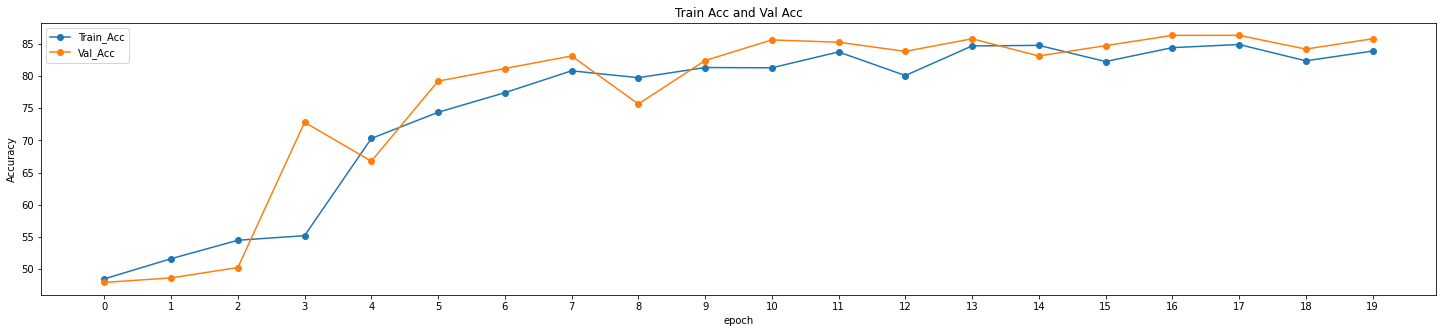

In [28]:
trainer.plot_his_acc()

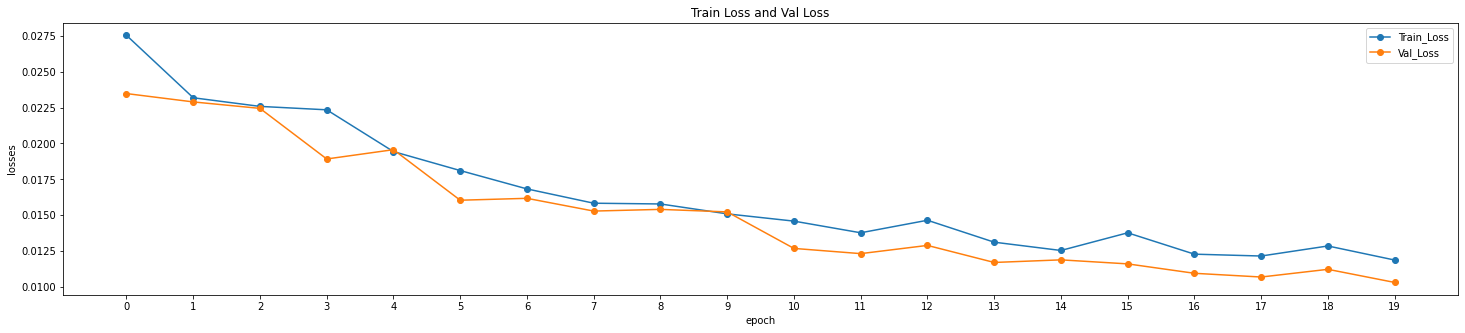

In [29]:
trainer.plot_his_loss()

In [30]:
def evaluate_model(model, loader):
    model.eval()
    pred_list = []
    label_list = []
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        running_loss=0
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            _, predictions = torch.max(outputs, 1)
            pred_list.extend(predictions.cpu().numpy())
            label_list.extend(labels.cpu().numpy())
            n_samples += labels.shape[0]
            n_correct += (predictions == labels).sum().item()
        acc = 100.0 * n_correct / n_samples
    return acc, pred_list, label_list

In [31]:
acc, pred_list, label_list = evaluate_model(model, test_loader)
print(f'Accuracy of the network on the test images: {acc} %')

Accuracy of the network on the test images: 87.23404255319149 %
